# Exploring PyMC for Bayesian Modeling (Part 2)

## Import Packages

In [1]:
import pymc as pm
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
figsize = [12, 4]
plt.rcParams["figure.figsize"] = figsize
rng = np.random.default_rng(1234)

## Simpson's Paradox

In [3]:
def generate():
    group_list = ["Grp A", "Grp B", "Grp C", "Grp D", "Grp E"]
    trials_per_group = 200
    
    group_intercepts = np.array([10, 7, 4, 1, -2]) 
    group_slopes = np.ones(len(group_list)) * -1
    
    group_mx = 1.2 * group_intercepts
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list


data, group_list = generate()

In [4]:
display(data)

group  group_idx          x          y
0    Grp A          0  10.396163  11.738618
1    Grp A          0  12.064100  10.863049
2    Grp A          0  12.740891  10.257532
3    Grp A          0  12.152619   9.841479
4    Grp A          0  12.863744   9.055495
..     ...        ...        ...        ...
995  Grp E          4  -3.388017  -0.194734
996  Grp E          4  -1.615920  -2.274315
997  Grp E          4  -2.325190  -0.261288
998  Grp E          4  -2.026604  -2.780806
999  Grp E          4  -3.056434  -3.263126

[1000 rows x 4 columns]

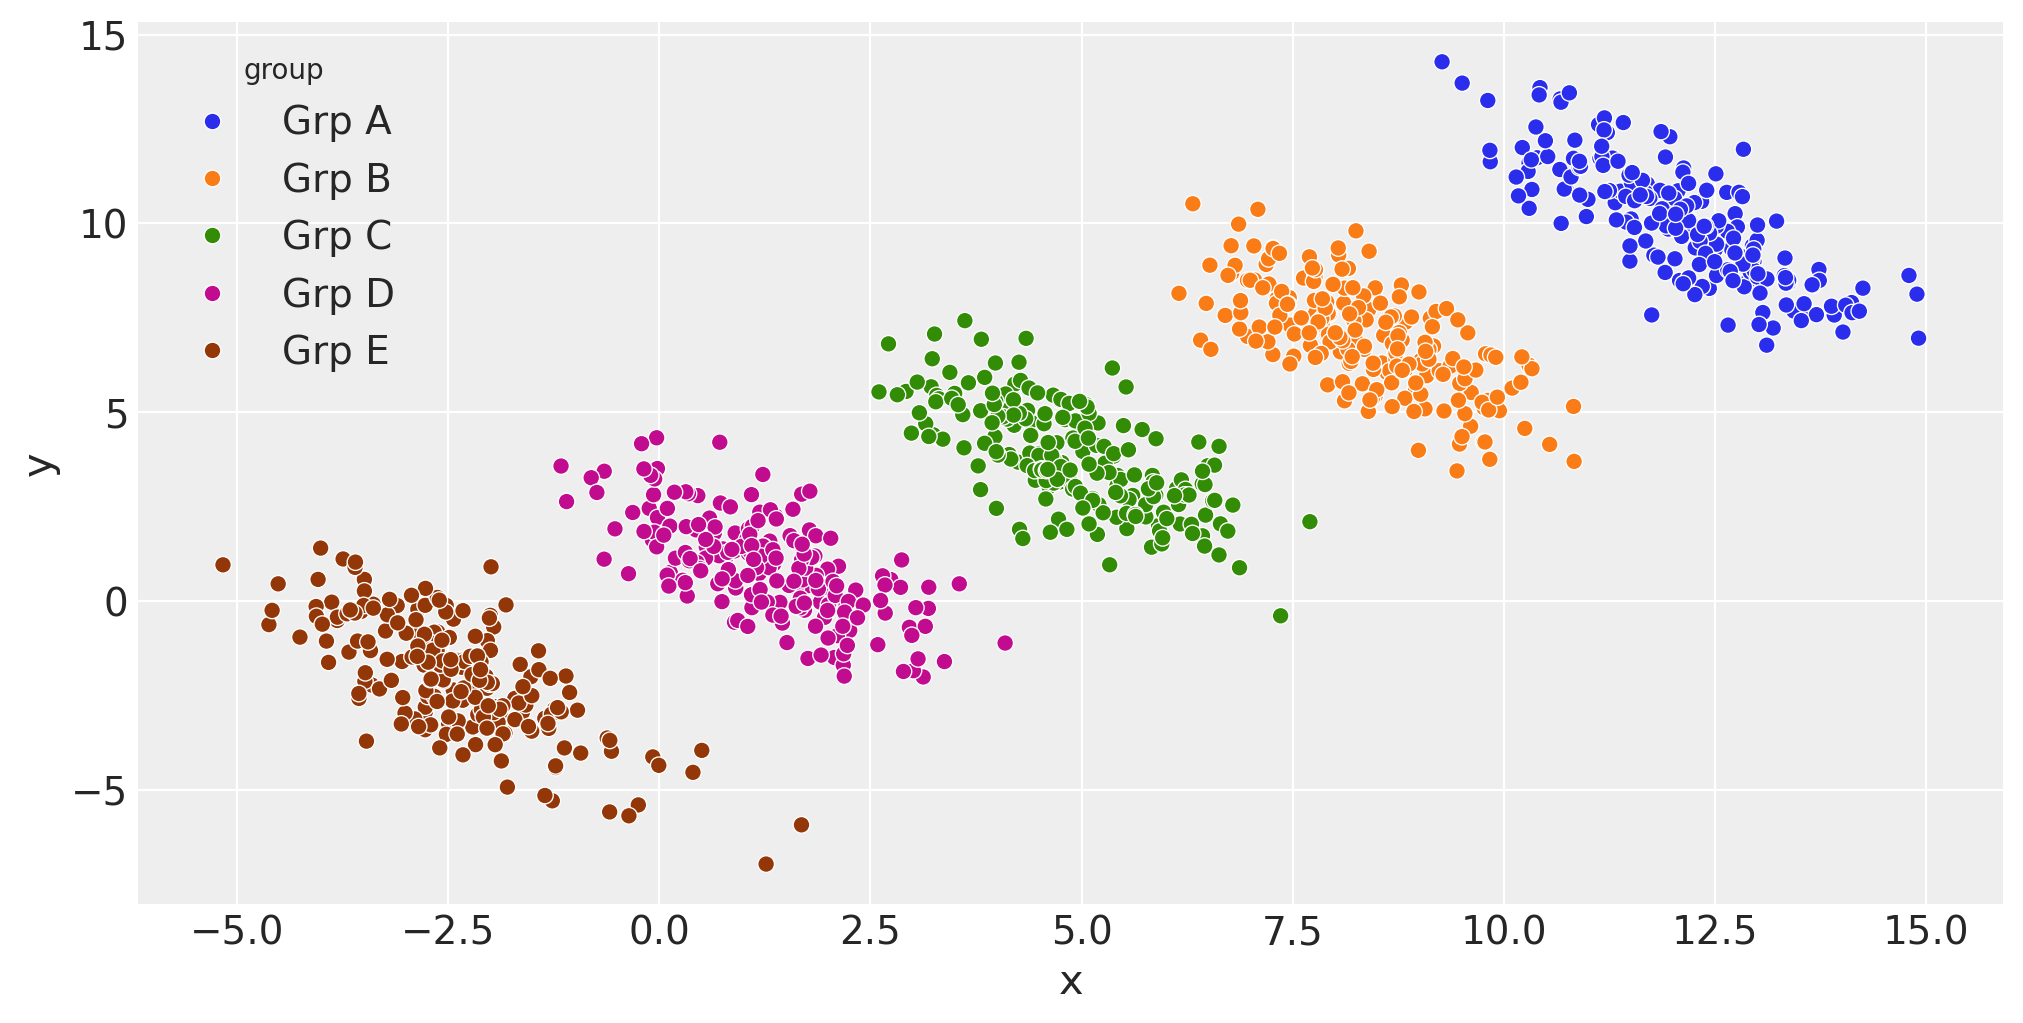

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=data, x="x", y="y", hue="group", ax=ax);

## Pooled Regression

In [6]:
with pm.Model() as pooled_model:
    β0 = pm.Normal("β0", 0, 5)
    β1 = pm.Normal("β1", 0, 5)
    σ = pm.Gamma("σ", 2, 2)
    x = pm.Data("x", data.x)
    μ = β0 + β1 * x # pm.Deterministic("μ", β0 + β1 * x)
    pm.Normal("y", mu=μ, sigma=σ, observed=data.y)

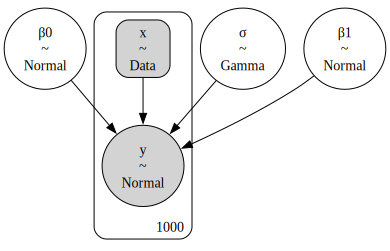

In [7]:
pm.model_to_graphviz(pooled_model)

In [8]:
with pooled_model:
    idata_pooled_model = pm.sample(draws=4000,
                                   tune = 1000,
                                   chains = 4,
                                   cores = 2,
                                   nuts_sampler = "pymc",
                                   discard_tuned_samples = True,
                                   compute_convergence_checks = True,
                                   return_inferencedata = True,
                                   idata_kwargs = {"log_likelihood": True},
                                   nuts_sampler_kwargs = {"target_accept":0.95})
    idata_pooled_model.extend(pm.sample_posterior_predictive(idata_pooled_model, 
                                                             var_names=["y"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β0, β1, σ]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 57 seconds.
Sampling: [y]


Output()

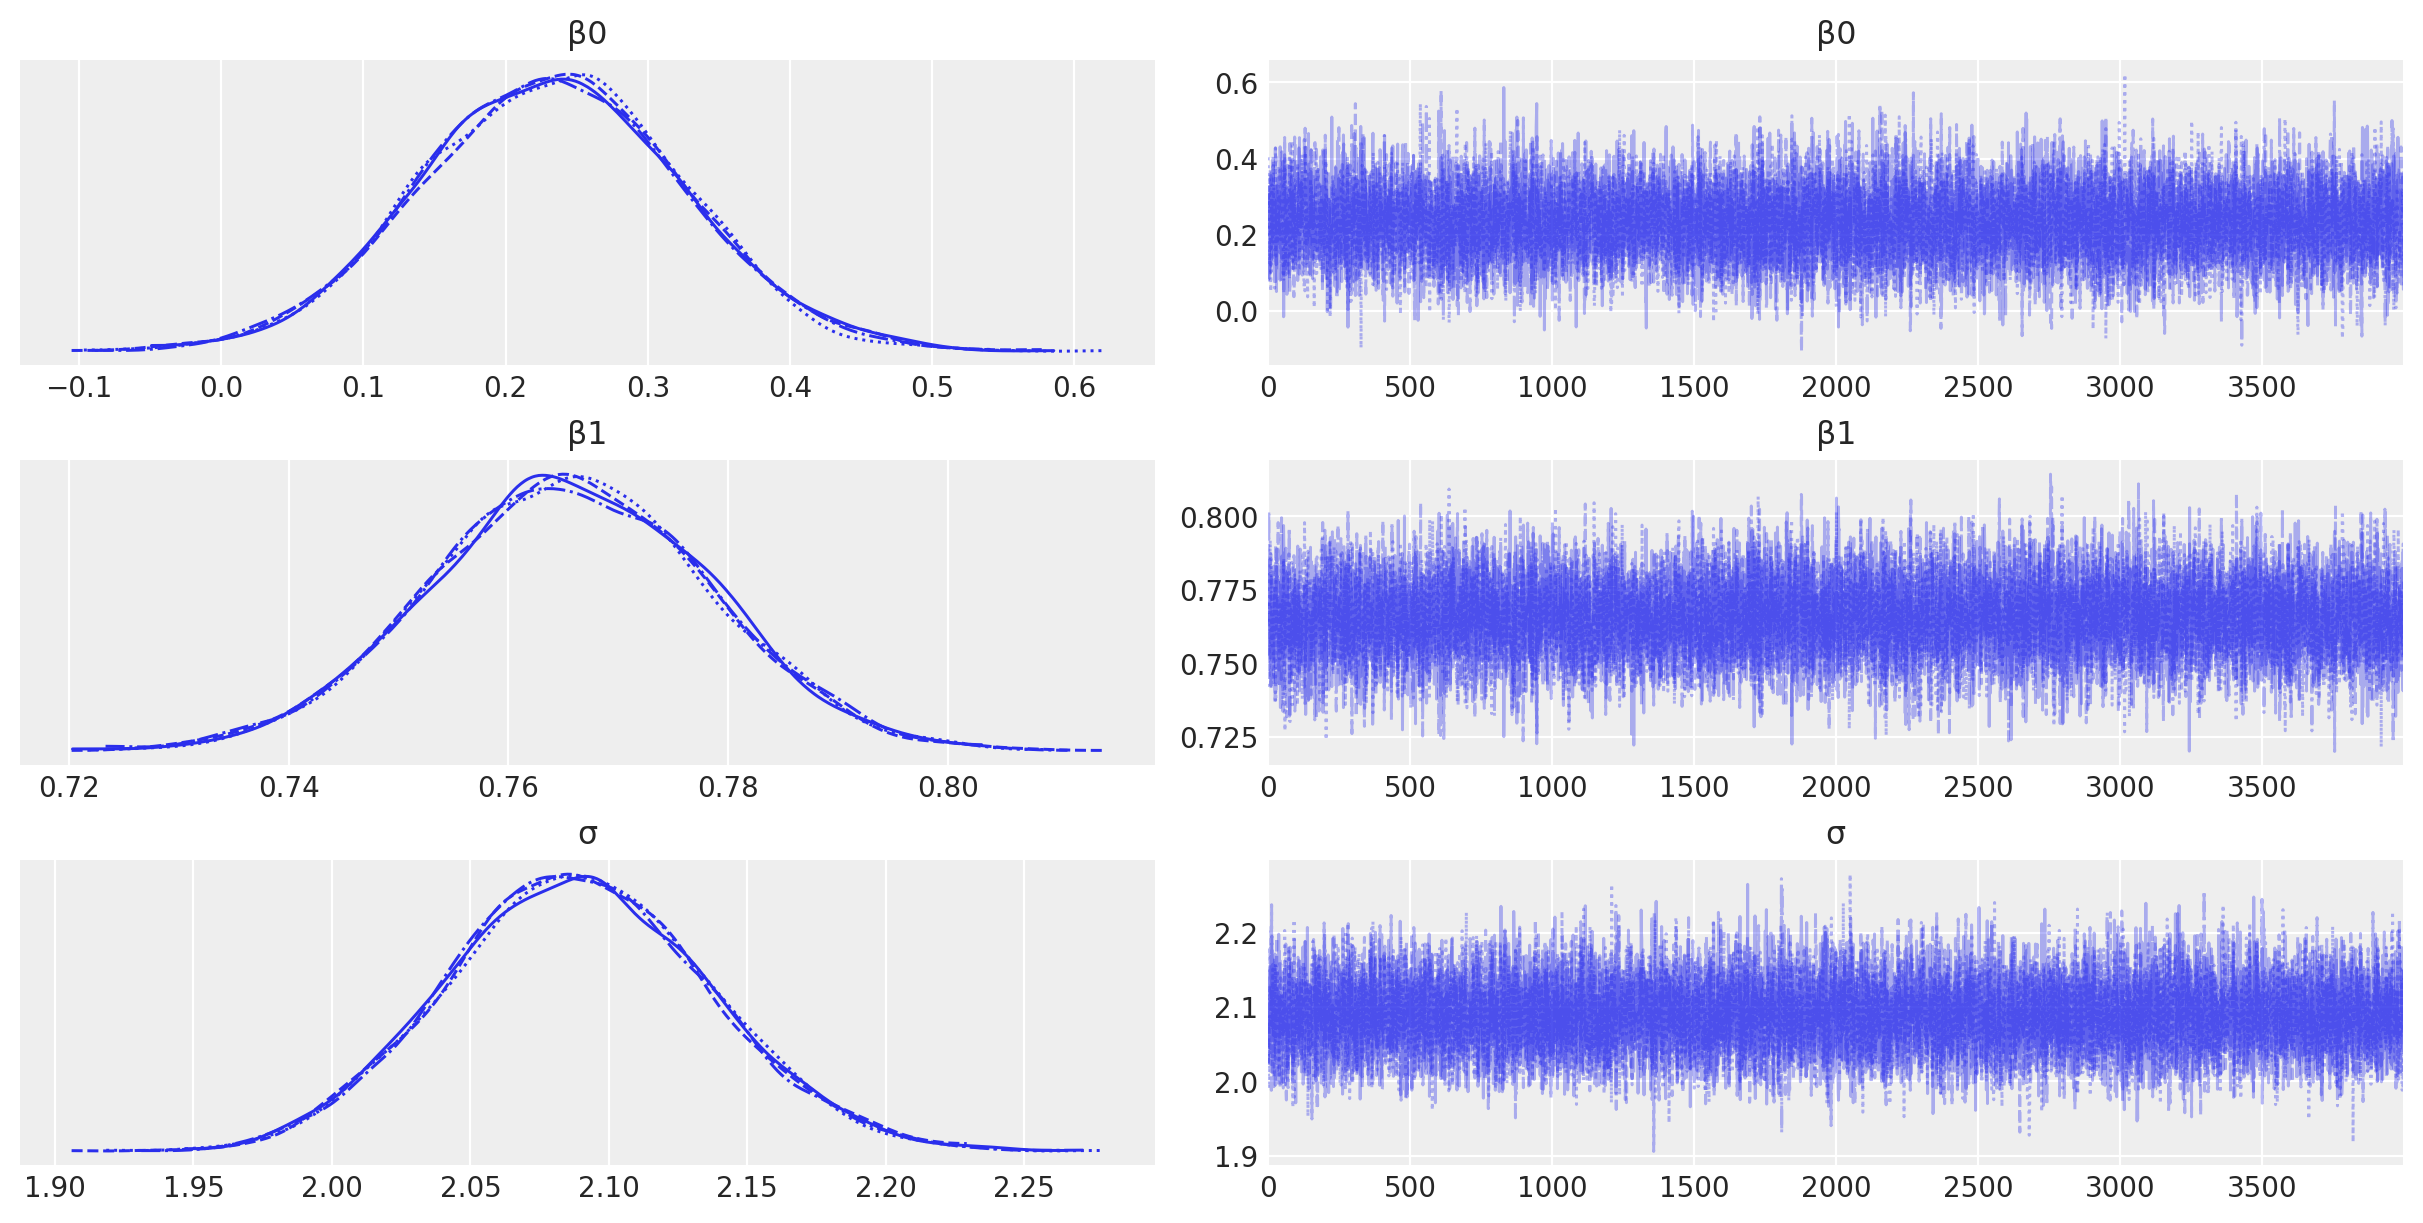

In [9]:
az.plot_trace(idata_pooled_model, var_names=["β0", "β1", "σ"]);

In [10]:
az.summary(idata_pooled_model, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
β0  0.233  0.092     0.051      0.411      0.001    0.001    9661.0   10780.0   
β1  0.765  0.013     0.741      0.791      0.000    0.000    9695.0   10358.0   
σ   2.089  0.047     1.996      2.180      0.000    0.000   12674.0   11417.0   

    r_hat  
β0    1.0  
β1    1.0  
σ     1.0

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

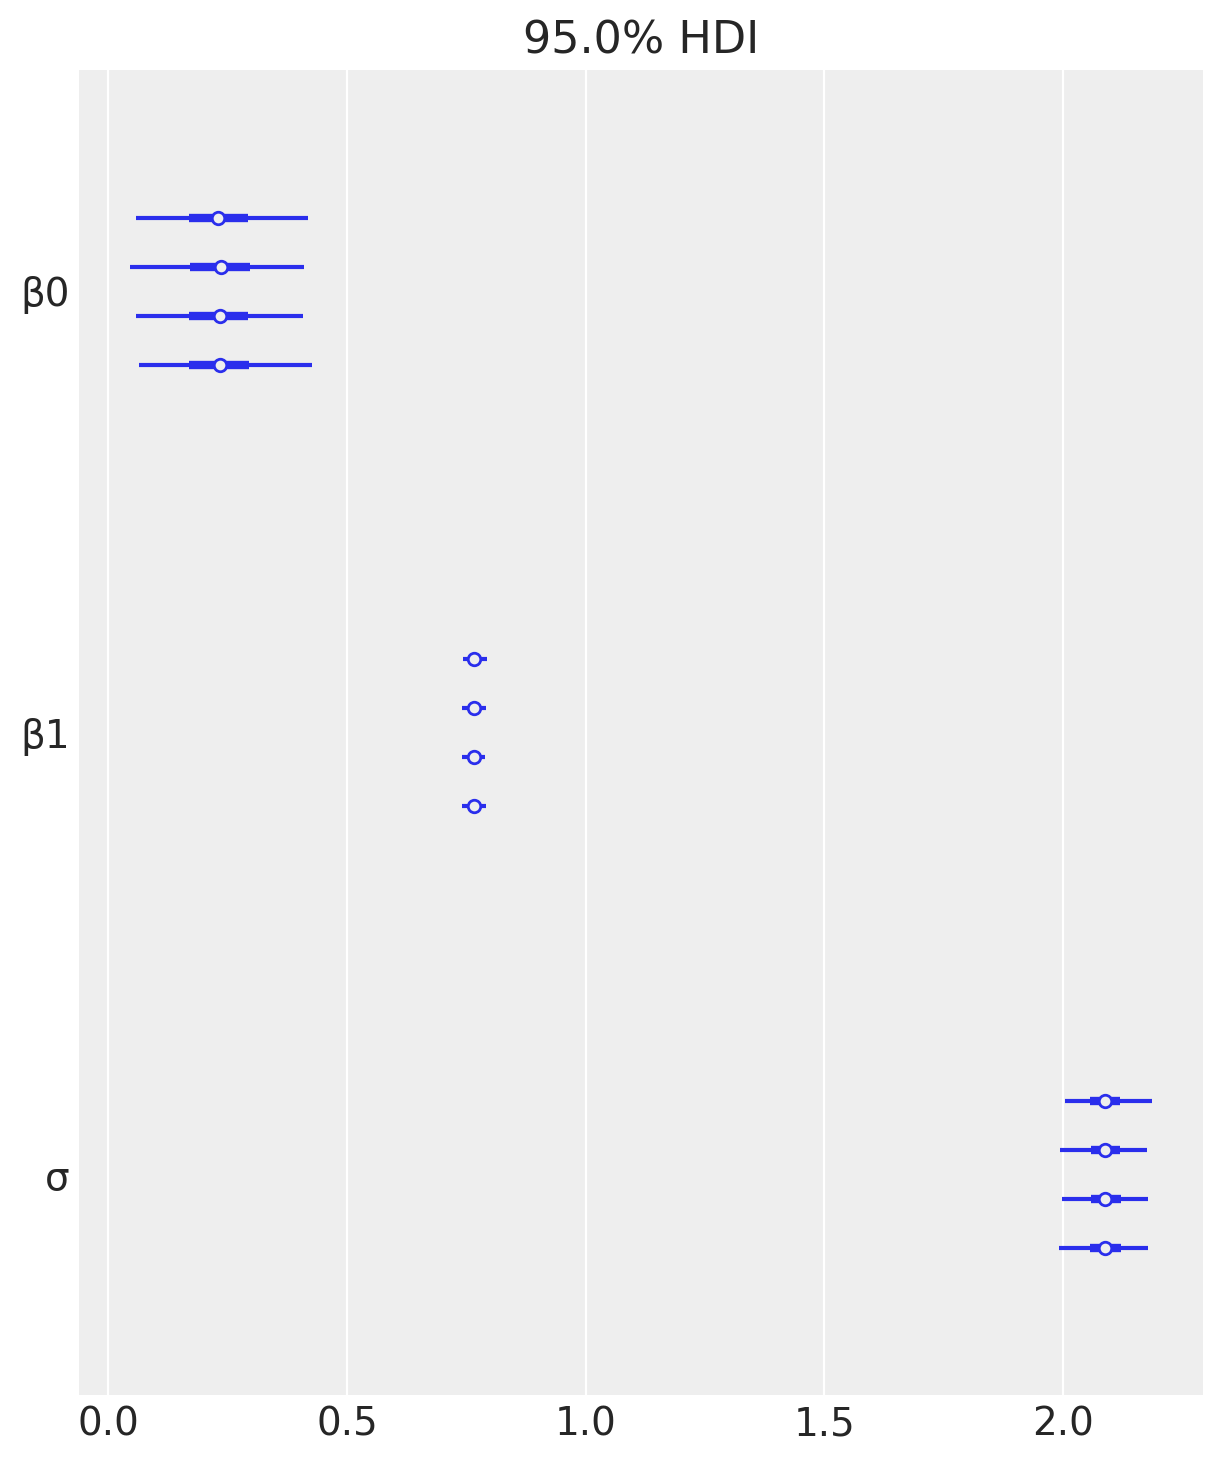

In [11]:
az.plot_forest(idata_pooled_model, 
               var_names=["β0", "β1", "σ"], 
               hdi_prob=0.95)

<Axes: xlabel='y'>

C:\Users\tumpa\Documents\Tanmay Sarkar\workspace\probabilistic-programming\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\tumpa\Documents\Tanmay Sarkar\workspace\probabilistic-programming\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


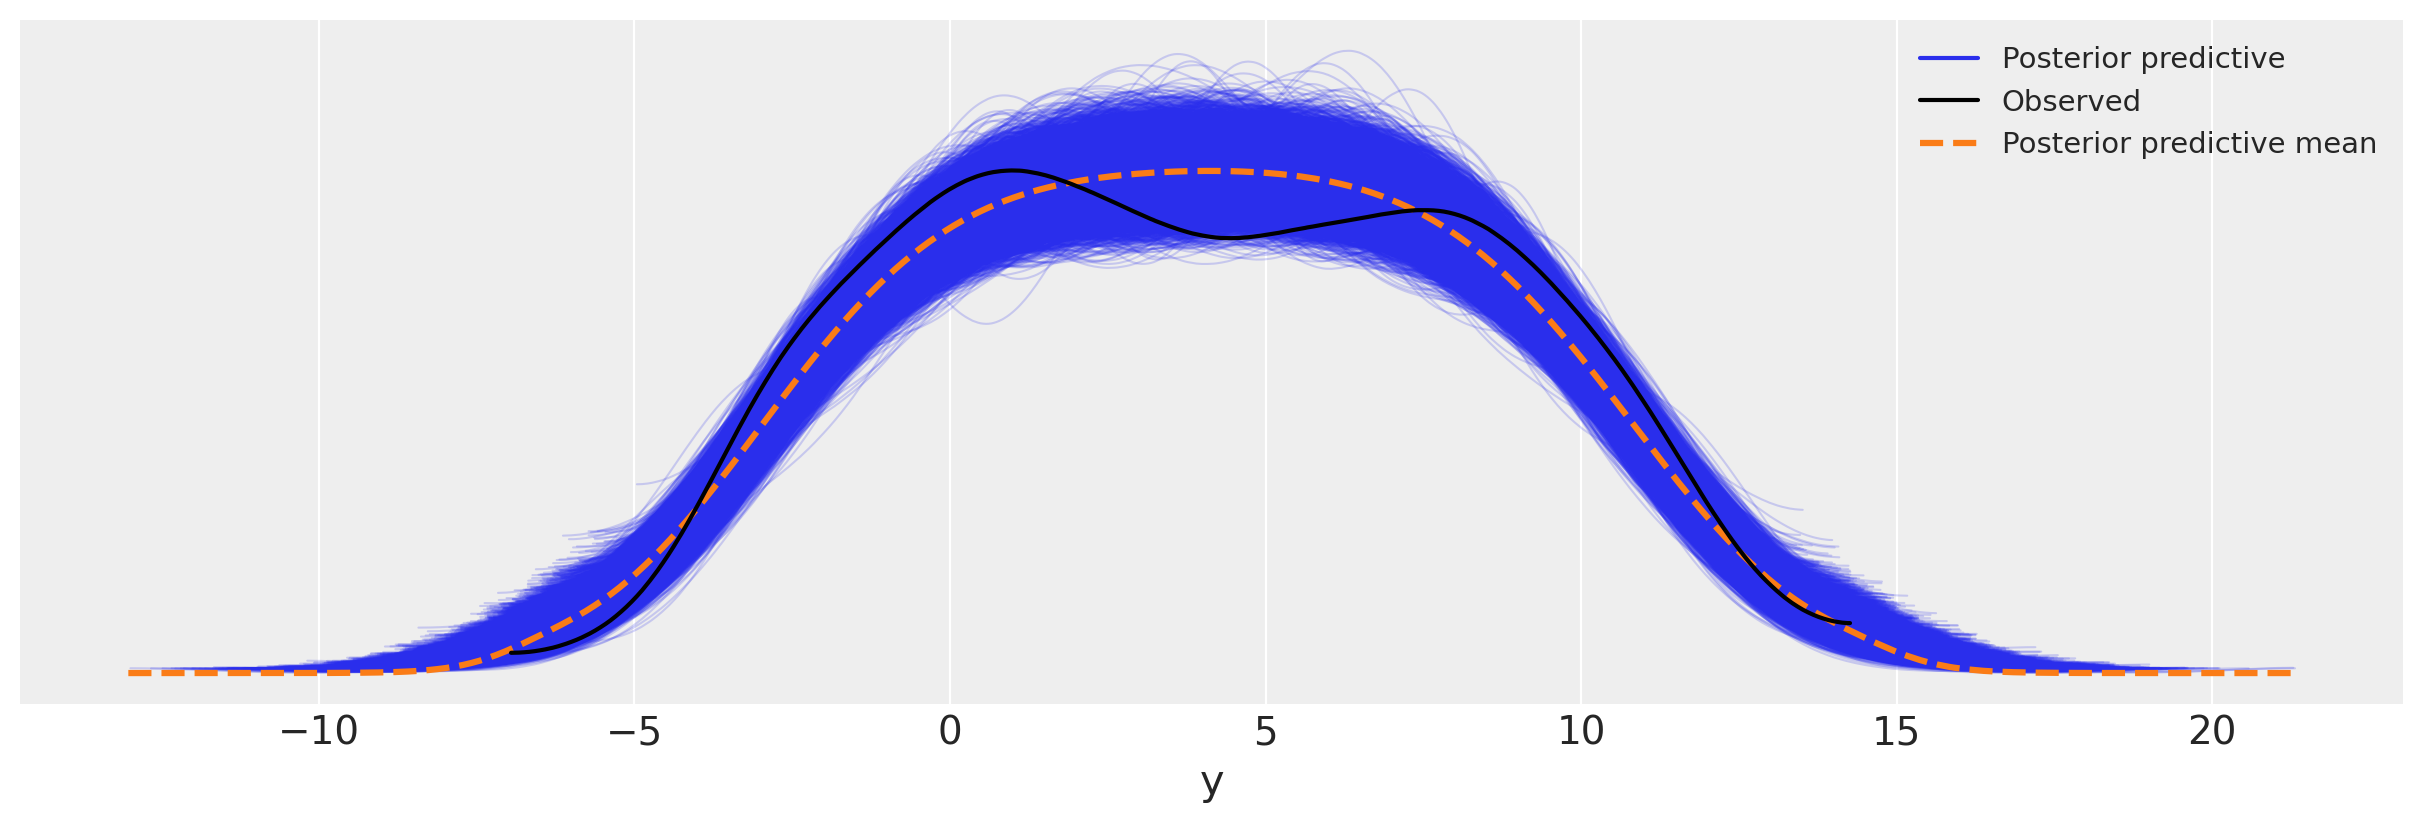

In [12]:
az.plot_ppc(idata_pooled_model)

In [13]:
az.loo(idata_pooled_model)

Computed from 16000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2157.93    22.47
p_loo        3.04        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Unpooled Regression

In [14]:
coords = {"group": group_list}

with pm.Model(coords=coords) as unpooled_model:
    # Define priors
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    σ = pm.Gamma("σ", 2, 2)
    
    # Data
    x = pm.Data("x", data.x, dims="obs_id")
    g = pm.Data("g", data.group_idx, dims="obs_id")
    
    # Linear model
    μ = β0[g] + β1[g] * x # pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=σ, observed=data.y, dims="obs_id")

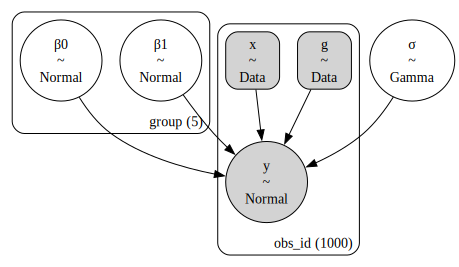

In [15]:
pm.model_to_graphviz(unpooled_model)

In [16]:
with unpooled_model:
    idata_unpooled_model = pm.sample(draws=4000,                                   
                                     tune = 1000,                                   
                                     chains = 4,                                   
                                     cores = 2,                                   
                                     nuts_sampler = "pymc",                                   
                                     discard_tuned_samples = True,                                   
                                     compute_convergence_checks = True,                                   
                                     return_inferencedata = True,                                   
                                     idata_kwargs = {"log_likelihood": True},                                   
                                     nuts_sampler_kwargs = {"target_accept":0.95})
    idata_unpooled_model.extend(pm.sample_posterior_predictive(idata_unpooled_model, 
                                                             var_names=["y"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β0, β1, σ]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 364 seconds.
Sampling: [y]


Output()

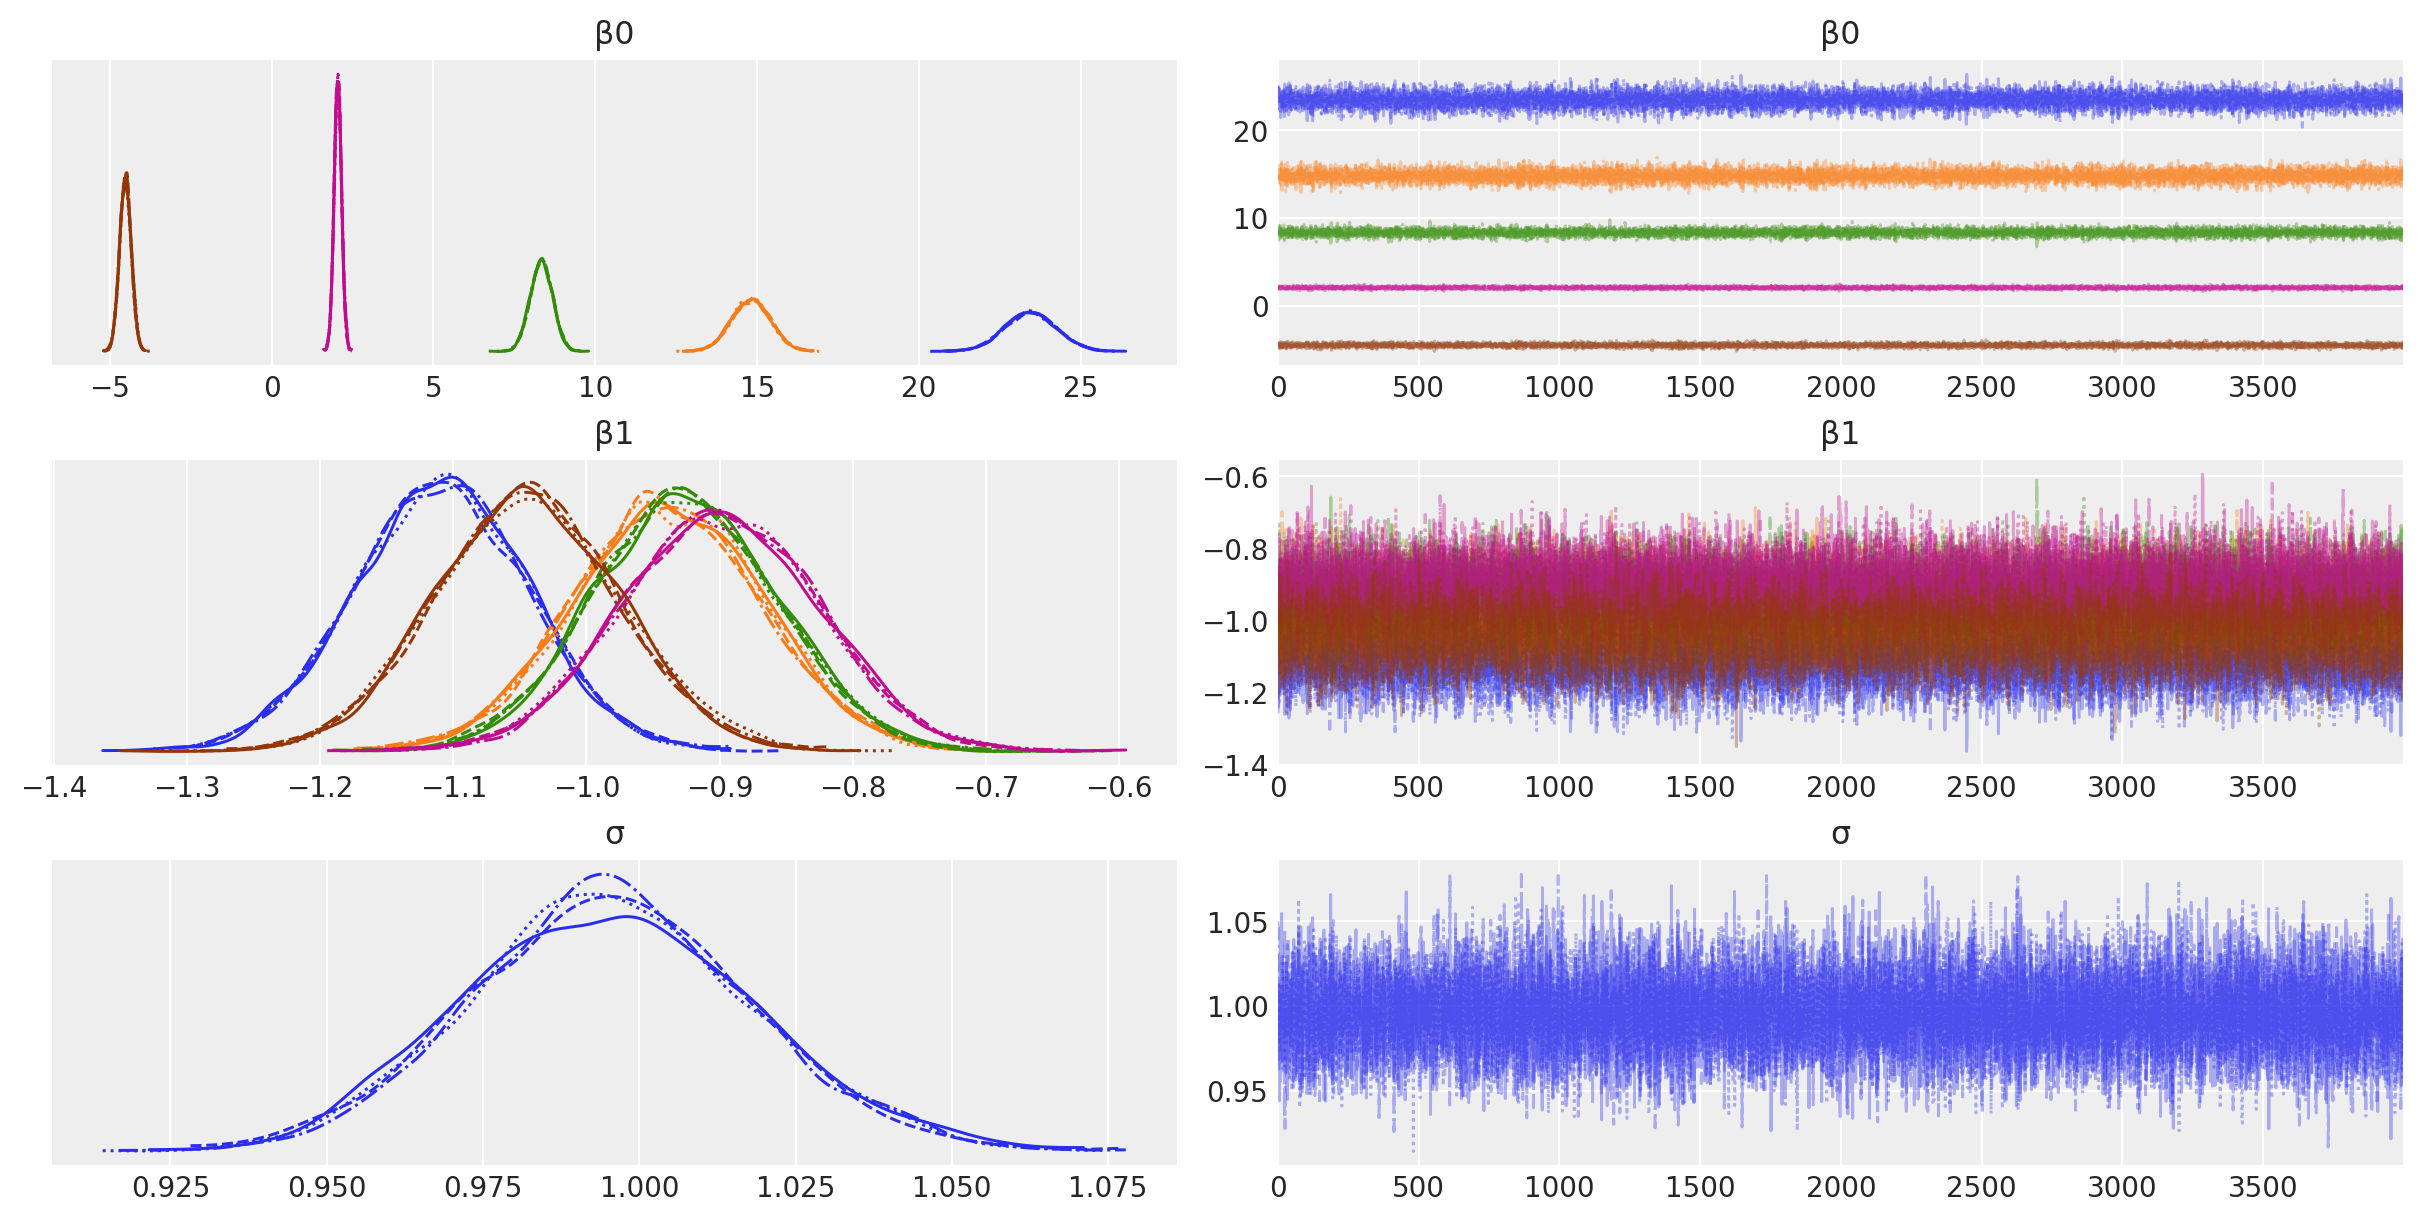

In [17]:
az.plot_trace(idata_unpooled_model, var_names=["β0", "β1", "σ"]);

In [18]:
az.summary(idata_unpooled_model, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
β0[Grp A]  23.444  0.792    21.913     25.027      0.007    0.005   14692.0   
β0[Grp B]  14.807  0.595    13.696     16.029      0.005    0.004   14264.0   
β0[Grp C]   8.332  0.341     7.674      9.007      0.003    0.002   15892.0   
β0[Grp D]   2.047  0.116     1.821      2.280      0.001    0.001   15667.0   
β0[Grp E]  -4.515  0.180    -4.878     -4.176      0.001    0.001   15016.0   
β1[Grp A]  -1.109  0.065    -1.237     -0.981      0.001    0.000   14668.0   
β1[Grp B]  -0.939  0.071    -1.080     -0.803      0.001    0.000   14174.0   
β1[Grp C]  -0.926  0.068    -1.059     -0.793      0.001    0.000   15879.0   
β1[Grp D]  -0.900  0.073    -1.039     -0.756      0.001    0.000   16223.0   
β1[Grp E]  -1.045  0.069    -1.177     -0.908      0.001    0.000   14982.0   
σ           0.995  0.023     0.951      1.040      0.000    0.000   18939.0   

           ess_tail  r_hat  
β0[Grp A]   10469.0    1.0  
β0[Grp B]   10598.0    1.0  
β0[Grp C]   10759.0    1.0  
β0[Grp D]   11047.0    1.0  
β0[Grp E]   11379.0    1.0  
β1[Grp A]   10505.0    1.0  
β1[Grp B]   10742.0    1.0  
β1[Grp C]   10815.0    1.0  
β1[Grp D]   10940.0    1.0  
β1[Grp E]   11186.0    1.0  
σ           10525.0    1.0

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

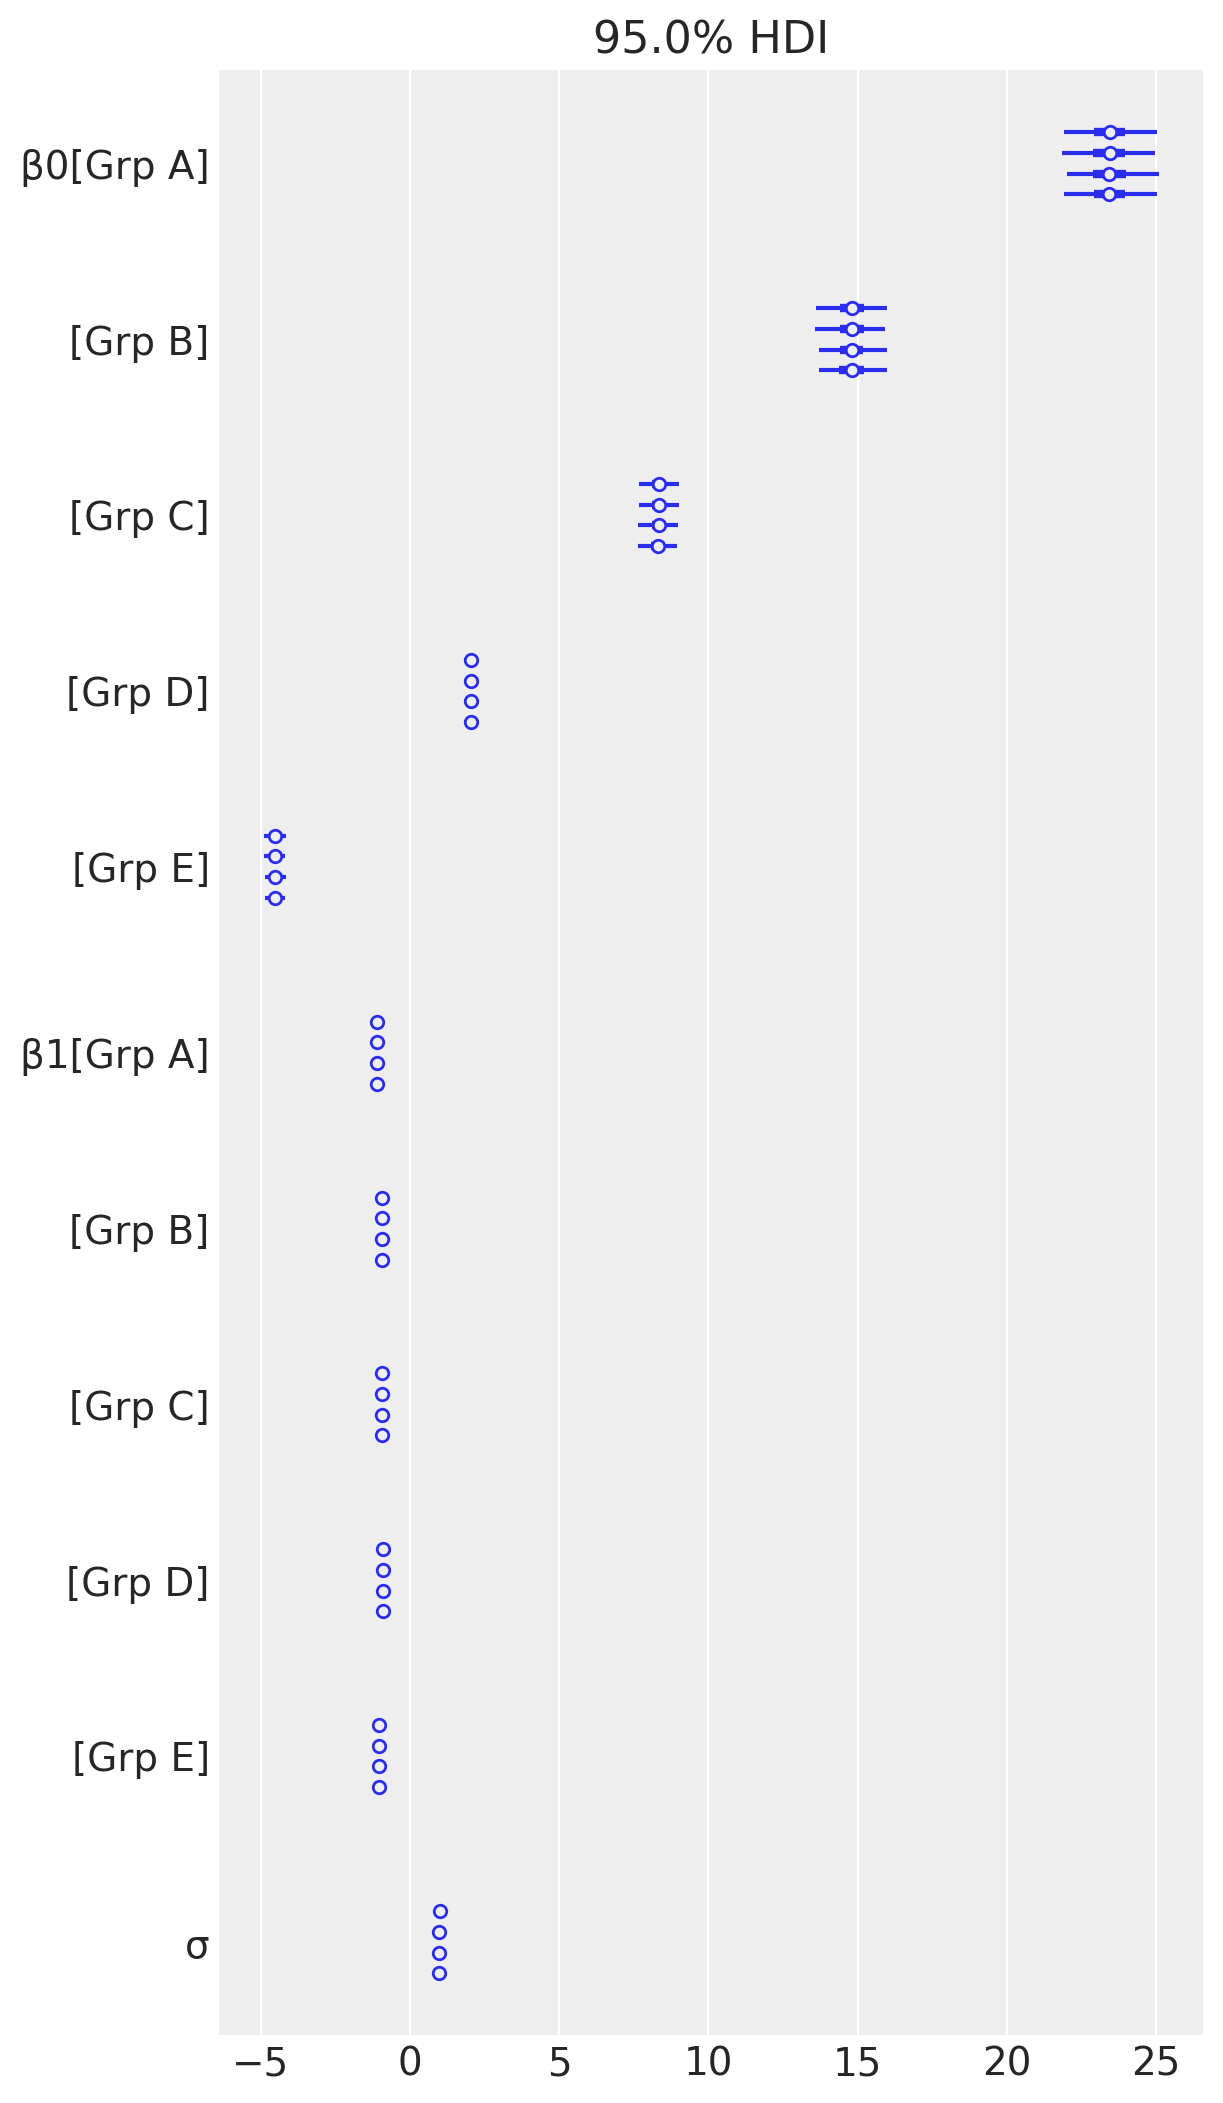

In [19]:
az.plot_forest(idata_unpooled_model, 
               var_names=["β0", "β1", "σ"], 
               hdi_prob=0.95)

<Axes: xlabel='y'>

C:\Users\tumpa\Documents\Tanmay Sarkar\workspace\probabilistic-programming\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\tumpa\Documents\Tanmay Sarkar\workspace\probabilistic-programming\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


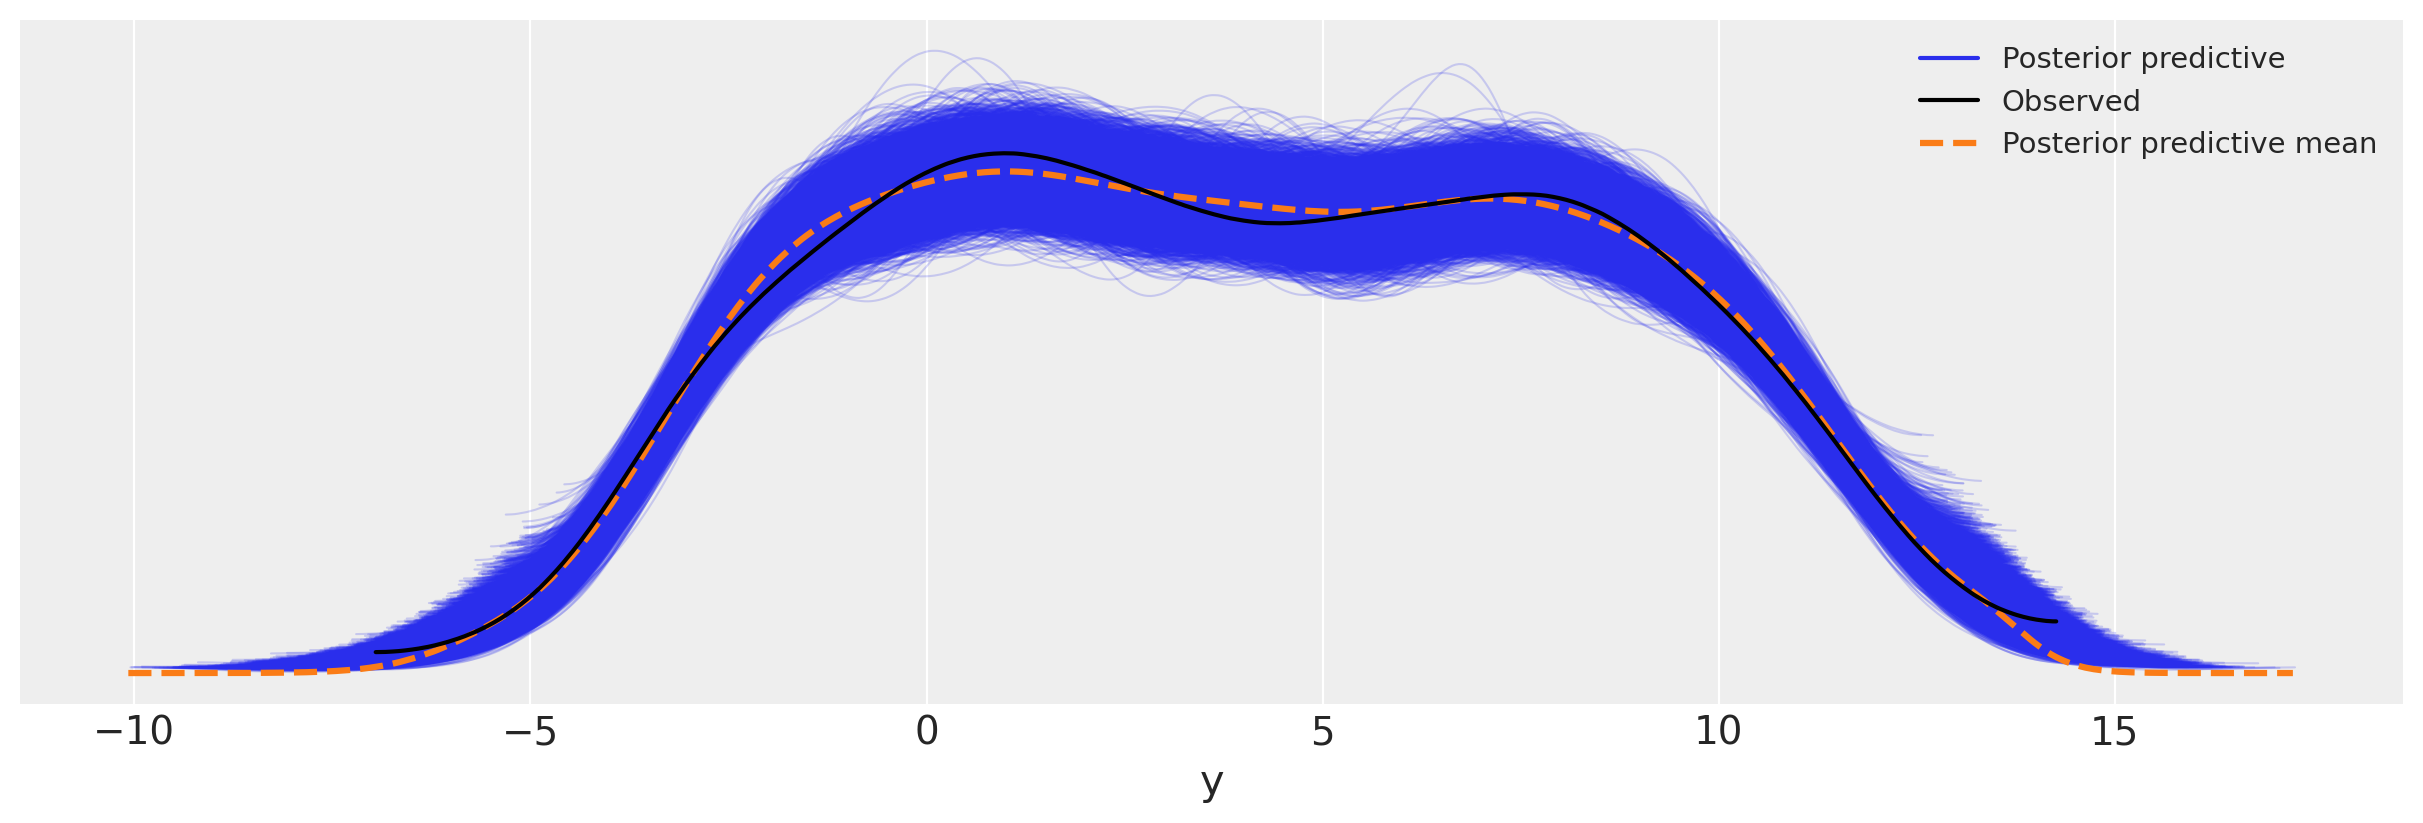

In [20]:
az.plot_ppc(idata_unpooled_model)

In [21]:
az.loo(idata_unpooled_model)

Computed from 16000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1419.52    21.88
p_loo       10.45        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Partial Pooling Model

In [22]:
coords = {"group": group_list}

with pm.Model(coords=coords) as partial_pooling_model:
    # Population level priors
    β_intercept = pm.Normal("β_intercept", 0, 5)
    β_slope = pm.Normal("β_slope", 0, 5)
    # observations noise prior
    σ = pm.Gamma("σ", 2, 2)

    # Group level shrinkage
    σ_intercept = pm.Gamma("σ_intercept", 2, 2) 
    σ_slope = pm.Gamma("σ_slope", 2, 2)
    # Group level deflections
    δ_intercept = pm.Normal("δ_intercept", 0, σ_intercept, dims="group")
    δ_slope = pm.Normal("δ_slope", 0, σ_slope, dims="group")
    
    # Data
    x = pm.Data("x", data.x, dims="obs_id")
    g = pm.Data("g", data.group_idx, dims="obs_id")
    
    # Linear model
    μ = (β_intercept + δ_intercept[g]) + (β_slope + δ_slope[g]) * x # pm.Deterministic("μ", (β0 + u0[g]) + (β1 * x + u1[g] * x), dims="obs_id")
    
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=σ, observed=data.y, dims="obs_id")

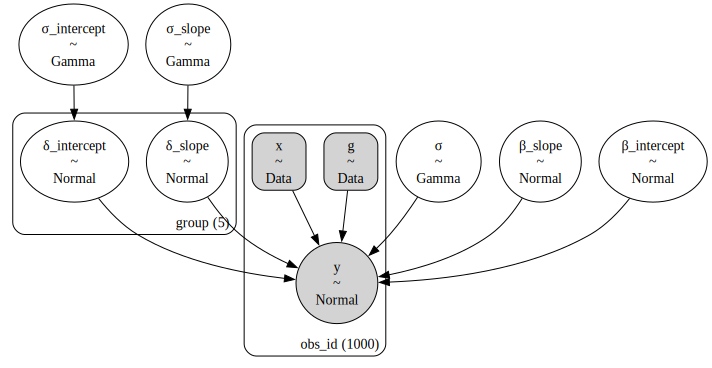

In [23]:
pm.model_to_graphviz(partial_pooling_model)

In [24]:
with partial_pooling_model:
    idata_partial_pooling_model = pm.sample(draws=4000,
                                            tune = 1000,                                   
                                            chains = 4,                                   
                                            cores = 2,                                   
                                            nuts_sampler = "pymc",                                   
                                            discard_tuned_samples = True,                                   
                                            compute_convergence_checks = True,                                   
                                            return_inferencedata = True,                                   
                                            idata_kwargs = {"log_likelihood": True},                                   
                                            nuts_sampler_kwargs = {"target_accept":0.95})
    idata_partial_pooling_model.extend(pm.sample_posterior_predictive(idata_partial_pooling_model, var_names=["y"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β_intercept, β_slope, σ, σ_intercept, σ_slope, δ_intercept, δ_slope]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2030 seconds.
Sampling: [y]


Output()

array([[<Axes: title={'center': 'β_intercept'}>,
        <Axes: title={'center': 'β_intercept'}>],
       [<Axes: title={'center': 'β_slope'}>,
        <Axes: title={'center': 'β_slope'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ_intercept'}>,
        <Axes: title={'center': 'σ_intercept'}>],
       [<Axes: title={'center': 'σ_slope'}>,
        <Axes: title={'center': 'σ_slope'}>],
       [<Axes: title={'center': 'δ_intercept'}>,
        <Axes: title={'center': 'δ_intercept'}>],
       [<Axes: title={'center': 'δ_slope'}>,
        <Axes: title={'center': 'δ_slope'}>]], dtype=object)

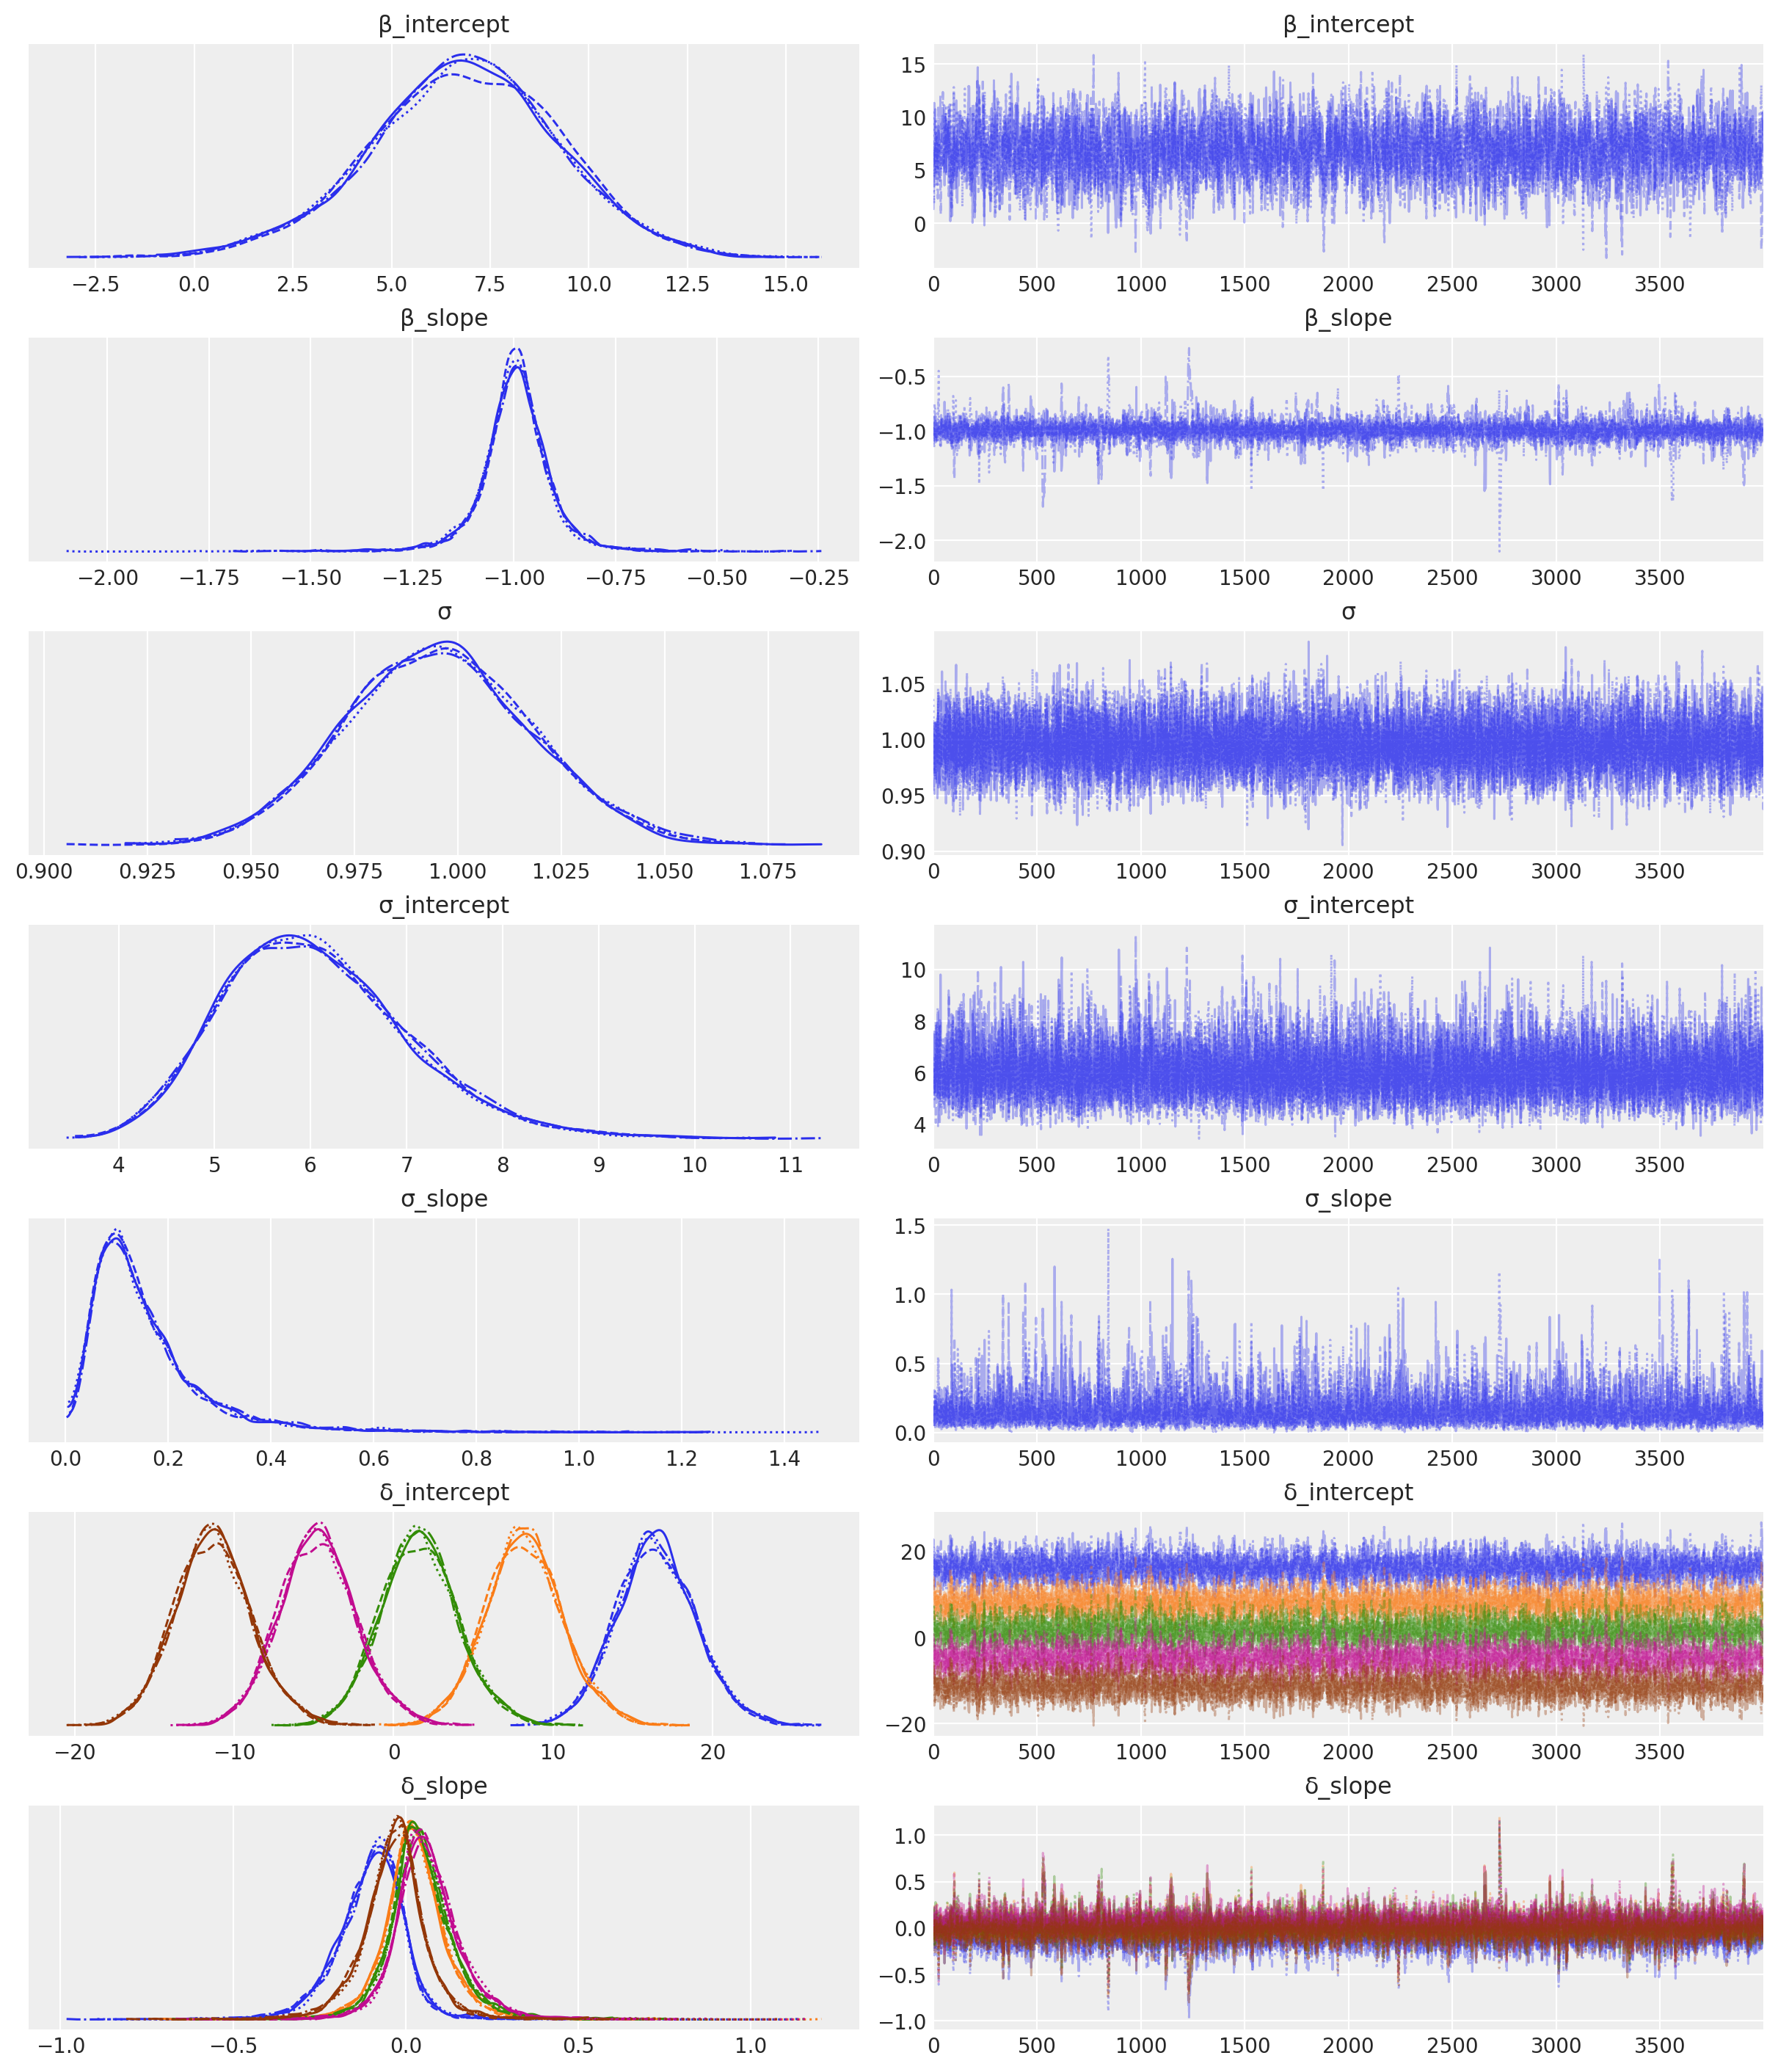

In [25]:
az.plot_trace(idata_partial_pooling_model, var_names=["β_intercept", "β_slope", "σ", "σ_intercept", "σ_slope", "δ_intercept", "δ_slope"])

In [26]:
az.summary(idata_partial_pooling_model, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
β_intercept          6.835  2.415     1.894     11.516      0.044    0.031   
β_slope             -0.996  0.092    -1.173     -0.815      0.002    0.001   
δ_intercept[Grp A]  16.457  2.523    11.485     21.446      0.045    0.032   
δ_intercept[Grp B]   8.212  2.457     3.645     13.417      0.044    0.031   
δ_intercept[Grp C]   1.614  2.430    -3.157      6.510      0.044    0.031   
δ_intercept[Grp D]  -4.750  2.416    -9.496      0.141      0.044    0.031   
δ_intercept[Grp E] -11.312  2.419   -16.036     -6.394      0.044    0.031   
δ_slope[Grp A]      -0.101  0.105    -0.309      0.085      0.002    0.002   
δ_slope[Grp B]       0.029  0.103    -0.166      0.242      0.002    0.002   
δ_slope[Grp C]       0.045  0.103    -0.156      0.248      0.002    0.002   
δ_slope[Grp D]       0.066  0.104    -0.120      0.284      0.002    0.002   
δ_slope[Grp E]      -0.034  0.101    -0.232      0.162      0.002    0.002   
σ                    0.995  0.023     0.952      1.040      0.000    0.000   
σ_intercept          6.061  0.978     4.276      7.985      0.010    0.007   
σ_slope              0.158  0.118     0.008      0.380      0.002    0.001   

                    ess_bulk  ess_tail  r_hat  
β_intercept           3057.0    3851.0    1.0  
β_slope               3318.0    2975.0    1.0  
δ_intercept[Grp A]    3162.0    4562.0    1.0  
δ_intercept[Grp B]    3146.0    4184.0    1.0  
δ_intercept[Grp C]    3103.0    4087.0    1.0  
δ_intercept[Grp D]    3065.0    3944.0    1.0  
δ_intercept[Grp E]    3070.0    3941.0    1.0  
δ_slope[Grp A]        3806.0    3763.0    1.0  
δ_slope[Grp B]        4085.0    3296.0    1.0  
δ_slope[Grp C]        3959.0    3242.0    1.0  
δ_slope[Grp D]        3893.0    3449.0    1.0  
δ_slope[Grp E]        3764.0    3734.0    1.0  
σ                    11818.0   10356.0    1.0  
σ_intercept          10068.0    9719.0    1.0  
σ_slope               3203.0    4852.0    1.0

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

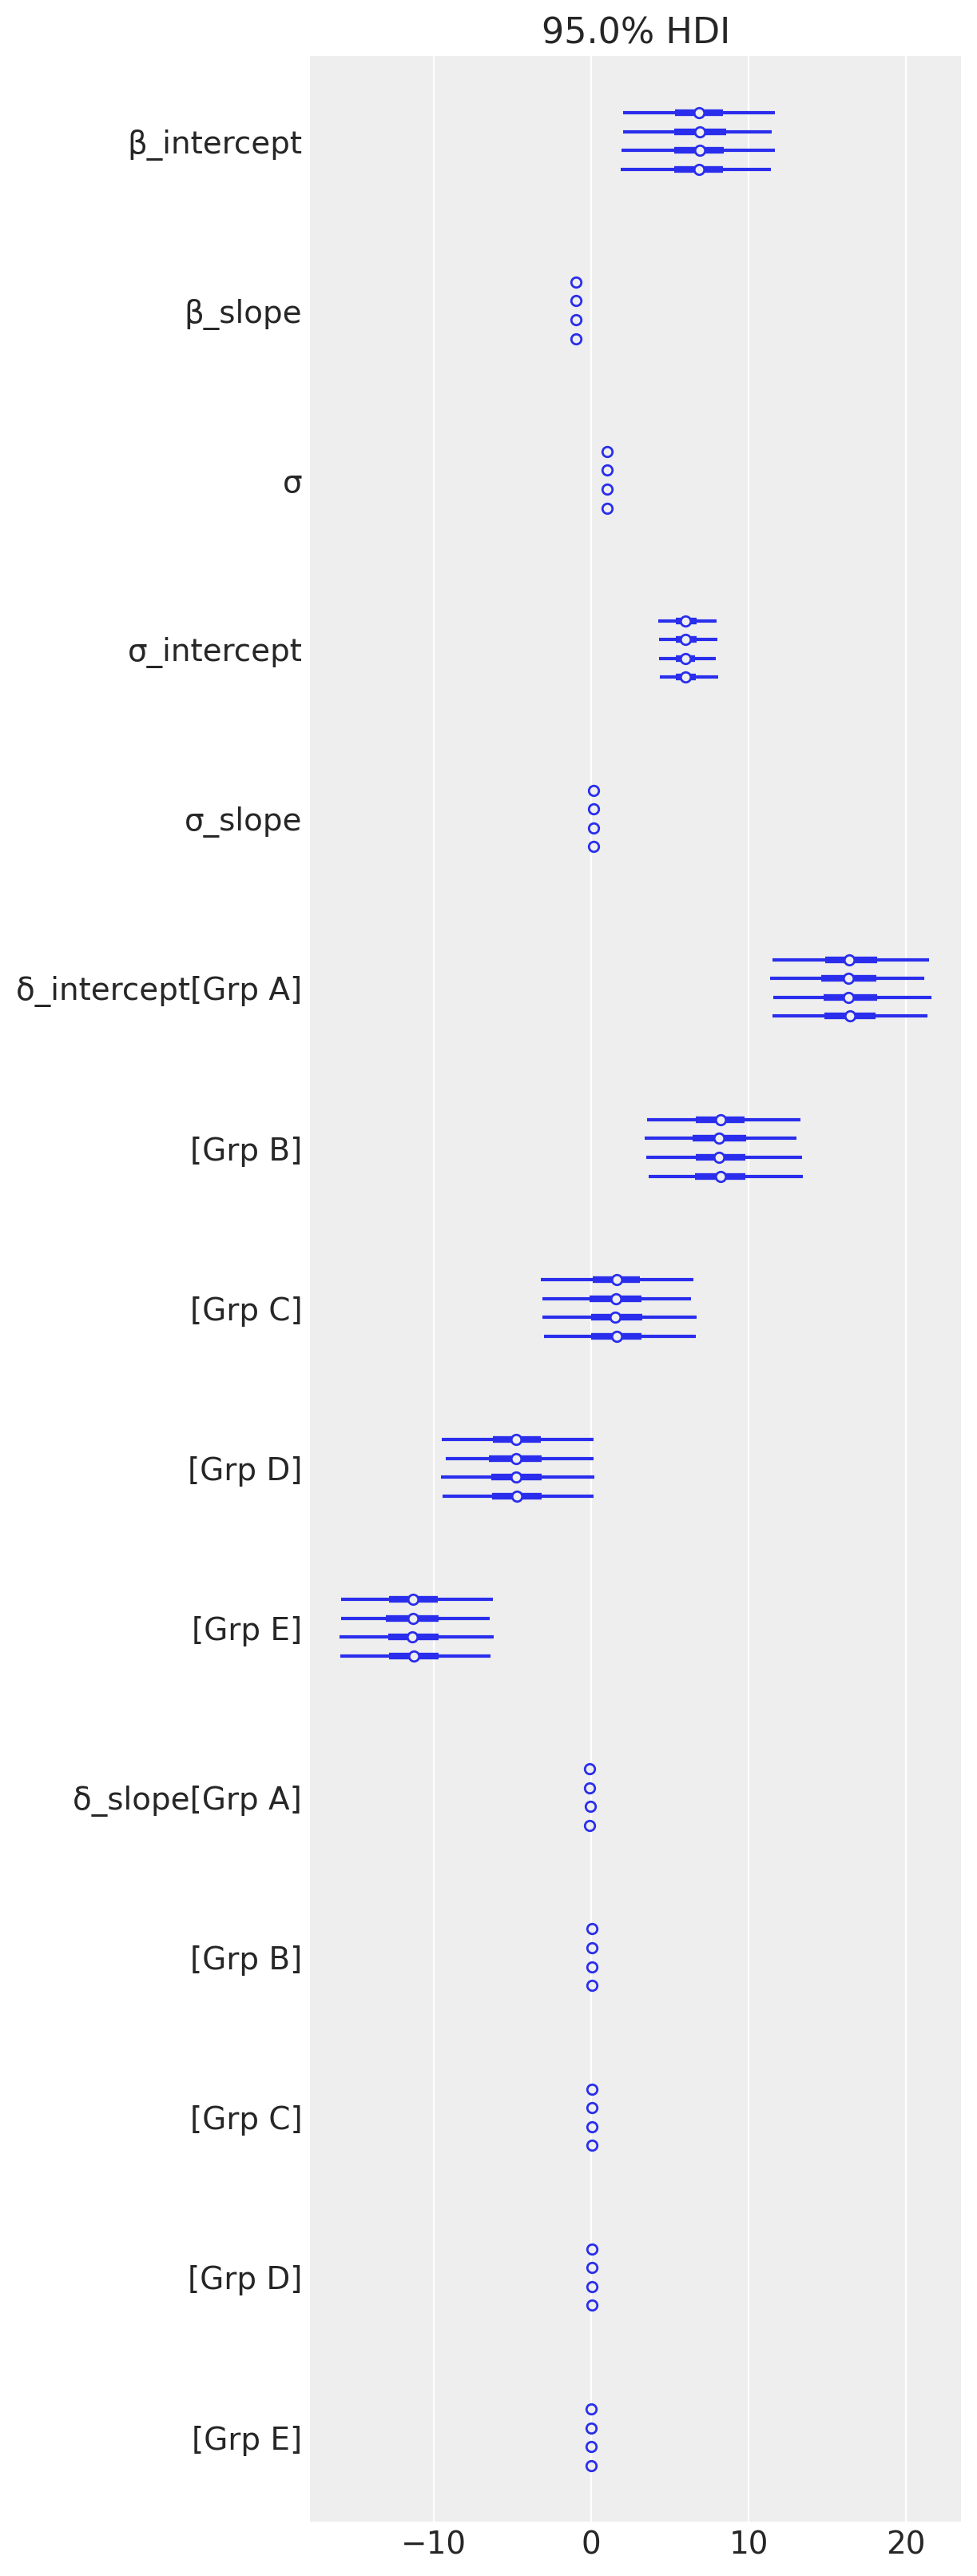

In [27]:
az.plot_forest(idata_partial_pooling_model, 
               var_names=["β_intercept", "β_slope", "σ", "σ_intercept", "σ_slope", "δ_intercept", "δ_slope"], 
               hdi_prob=0.95)

<Axes: xlabel='y'>

C:\Users\tumpa\Documents\Tanmay Sarkar\workspace\probabilistic-programming\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\tumpa\Documents\Tanmay Sarkar\workspace\probabilistic-programming\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


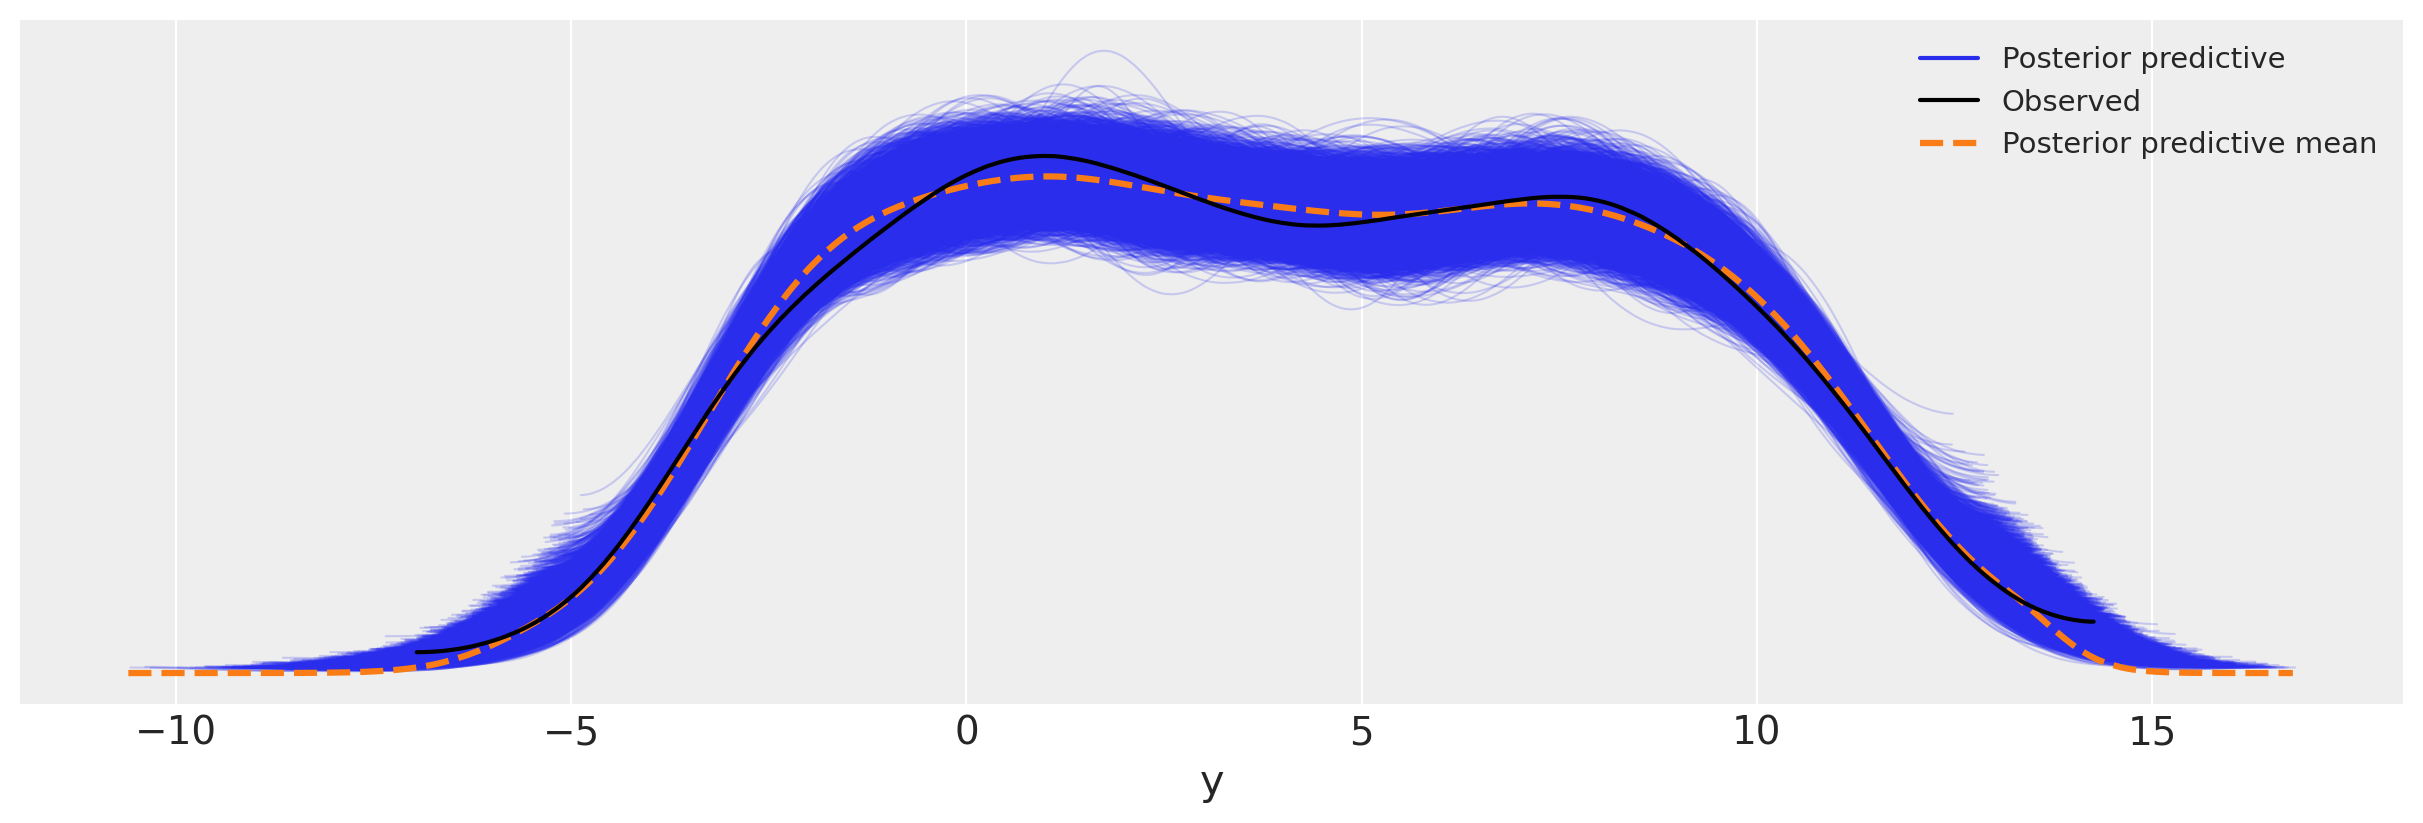

In [28]:
az.plot_ppc(idata_partial_pooling_model)

In [29]:
az.loo(idata_partial_pooling_model)

Computed from 16000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1419.00    21.84
p_loo        9.74        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%